#Multimodal

# Set up
---

## Install libraries

In [ ]:
!pip install transformers
!pip install iterative-stratification

## Imports

In [ ]:
import librosa
from transformers import AutoProcessor, Wav2Vec2ForSequenceClassification,AutoFeatureExtractor,Wav2Vec2Model, RobertaModel, AutoTokenizer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch
import os
import pandas as pd
from google.colab import drive
import numpy as np

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import ParameterGrid

from tabulate import tabulate
import math

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
import pytz

import pdb
import re

import librosa

pd.options.mode.chained_assignment = None

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

## Connect drive and select device

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Audio transformations
---

## Load audios

## Pre-compute embeddings

In [ ]:
def compute_embeddings(data,model,tokenizer):
  for question_ in tqdm(data.question.unique()):
    question_embeddings = {}
    question_d = data.loc[(data.question == question_)]


    median_intervetion = int(question_d.word_count.median())
    median_intervetion = median_intervetion if median_intervetion > 1 else 16
    median_intervetion = median_intervetion if median_intervetion < 512 else 512
    for id_ in data.loc[data.question == question_].patient_id.unique():
      text = data.loc[(data.patient_id==id_) & (data.question == question_)].intervention.values[0]

      input_values = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt').to("cuda")

      with torch.no_grad():
        mo = model(**input_values)

      embed = mo.last_hidden_state.squeeze()

      question_embeddings.setdefault(id_,embed)

    torch.save(question_embeddings,f"/content/gdrive/MyDrive/daiwoz/question_embeddings/roberta_{question_}_embeddings_base.pt")

In [ ]:
def compute_embeddings_questions(data):
  tokenizer = AutoTokenizer.from_pretrained("roberta-base")
  model = RobertaModel.from_pretrained("roberta-base").to("cuda")
  compute_embeddings(data,model,tokenizer)

data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/best_questions.csv",index_col=0).reset_index().rename(columns={"value":"intervention","id":"patient_id","index":"id"})
compute_embeddings_questions(data)

## Dataset

In [ ]:
class DWDataset(torch.utils.data.Dataset):
    """
    A PyTorch dataset for sentiment analysis.

    Args:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Attributes:
        data (pandas.DataFrame): The input data.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for tokenizing the text data.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(index): Returns a single sample from the dataset.
    """

    def __init__(self, data):
        self.data = data.reset_index(drop=True).reset_index().rename(columns={"index":"id"})
        self.data_labels= self.data['PHQ8_Binary'].values
        self.embeddings_wav2vec2 = self.get_embeddings_wav2vec2()
        self.embeddings_roberta = self.get_embeddings_roberta()


    def get_embeddings_wav2vec2(self):
      question = self.data.question.unique()[0]
      return torch.load(f"/content/gdrive/MyDrive/daiwoz/question_embeddings/{question}_embeddings_er.pt",)


    def get_embeddings_roberta(self):
      question = self.data.question.unique()[0]
      return torch.load(f"/content/gdrive/MyDrive/daiwoz/question_embeddings/roberta_{question}_embeddings_base.pt")

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """

        return len(self.data)


    def __getitem__(self, index):
        """
        Returns a single sample from the dataset.

        Args:
            index (int): The index of the sample to return.

        Returns:
            dict: A dictionary containing the input IDs, attention mask, and label.
        """

        label = self.data.iloc[index]['PHQ8_Binary']
        patient_id = self.data.iloc[index]['patient_id']
        embeddings_w = self.embeddings_wav2vec2[patient_id]
        embeddings_r = self.embeddings_roberta[patient_id]
        return {"embeddings_w":embeddings_w,
                "embeddings_r":embeddings_r,
                'label': torch.tensor(label),
                'patient_id':patient_id,
                "id":index}

# Utils

### Split function

In [ ]:
def split_dataset(df, test_size=0.25, val_size=0.2, random_state=42):
    # Ensure the 'gender' column is numerical
    if df['Gender'].dtype == 'object':
        df['Gender'] = df['Gender'].astype('category').cat.codes

    # Combine the 'gender' and 'label' columns into a new 2D array
    y = df[['Gender', 'PHQ8_Binary_mild']].values


    try:
      # Split the DataFrame into three equal parts representing short, medium, and long texts
      labels=['short', 'medium', 'long']
      df['text_length_category'] = pd.qcut(df['word_count'], 3, labels=labels)
    except:
      labels=['short', 'long']
      # Split into 'short' and 'long' based on the median
      median = df['word_count'].median()
      df['text_length_category'] = np.where(df['word_count'] <= median, 'short', 'long')


    df_result = pd.DataFrame()

    # Loop over each category
    for category in labels:
        df_temp = df[df['text_length_category'] == category]

        # Create the initial splitter
        initial_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        # Split out the test set
        for other_index, test_index in initial_split.split(df_temp, df_temp[['Gender', 'PHQ8_Binary']].values):
            df_other, df_test = df_temp.iloc[other_index], df_temp.iloc[test_index]

        # Now create a new splitter for splitting the remaining data into train and validation sets
        train_val_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)

        y_other = df_other[['Gender', 'PHQ8_Binary']].values

        # Split the remaining data into train and validation sets
        for train_index, val_index in train_val_split.split(df_other, y_other):
            df_train, df_val = df_other.iloc[train_index], df_other.iloc[val_index]

        # Now assign labels to each set
        df_train['split'] = 'train'
        df_val['split'] = 'validation'
        df_test['split'] = 'test'

        df_temp = pd.concat([df_train, df_val, df_test])

        df_result = pd.concat([df_result, df_temp])

    return df_result


from sklearn.model_selection import train_test_split

def split_dataset2(df, test_size=0.3, random_state=42):
    # Ensure 'Gender' and 'PHQ8_Binary' columns are categorical
    for col in ['Gender', 'PHQ8_Binary']:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes

    # Combine 'Gender' and 'PHQ8_Binary' into a new 2D array
    y = df[['Gender', 'PHQ8_Binary']].values

    # Initial split for train and (test + validation)
    df_train, df_temp, y_train, y_temp = train_test_split(df, y, test_size=test_size,
                                                           stratify=y, random_state=random_state)

    # Split (test + validation) into test and validation
    df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, test_size=0.5,
                                                      stratify=y_temp, random_state=random_state)

    # Assign labels to each set
    df_train['split'] = 'train'
    df_val['split'] = 'validation'
    df_test['split'] = 'test'

    return pd.concat([df_train, df_val, df_test])

  ### Preprocess

In [ ]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import resample

def preprocess_data(df):
    df.intervention = df.intervention.apply(lambda x: clean_text(x))
    df = split_dataset(df)


    return df



In [ ]:
def random_oversample(df,seed=42):
  # Separate the data based on class (assuming 'label' is the class column)
  # with 1 being the positive (minority) class
  df_minority = df[df['PHQ8_Binary_mild'] == 0]
  df_majority = df[df['PHQ8_Binary_mild'] == 1]

  # Perform oversampling on the minority class
  df_minority_oversampled = resample(df_minority,
                                      replace=True, # sample with replacement
                                      n_samples=int(len(df_majority)*0.95), # match number in majority class
                                      random_state=seed) # reproducible results

  # Combine the majority class with the oversampled minority class
  df_oversampled = pd.concat([df_majority, df_minority_oversampled])

  return df_oversampled

# Training functionalities
---

## Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, delta=0.00, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_max = -np.Inf
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, val_loss, model, train_dict, val_dict):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
        elif score > self.best_score:
            self.best_score = score
            self.best_train_dict = train_dict
            self.best_val_dict = val_dict
            self.save_checkpoint(val_f1, model)
        elif val_loss > self.val_loss_min + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss_min = val_loss
            self.counter = 0

    def save_checkpoint(self, val_f1, model):
        if self.verbose:
            print(f'Validation F1 increased ({self.val_f1_max:.6f} --> {val_f1:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_f1_max = val_f1


## Experiment


In [ ]:
class Experiment:
  def __init__(self,model,criterion,optimizer,scheduler,early_stopper,writer):
    self.criterion = criterion
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.early_stopping = early_stopper
    self.model = model
    self.tb = writer

  def fit(self,num_epochs,train_data,val_data,verbose=0):

    self.train_loss = []
    self.val_loss = []

    for epoch in range(num_epochs):
       if verbose==1:
        print(f"\n--- Epoch {epoch+1} ---")

       train_dict = self.loop(train_data,self.optimizer,self.criterion,epoch,is_train=True)
       val_dict = self.loop(val_data,self.optimizer,self.criterion,epoch,is_train=False)


       self.train_loss.append(train_dict["loss"])
       self.val_loss.append(val_dict["loss"])


       self.track_metrics(train_dict,epoch,"train")
       self.track_metrics(val_dict,epoch,"validation")

       self.scheduler.step()

       if verbose == 1:
        self.print_metrics(train_dict,"Train")
        self.print_metrics(val_dict,"Validation")

       current_F1 = self.get_metrics(val_dict)["F1"]

       self.early_stopping(current_F1,self.val_loss[-1], self.model, train_dict, val_dict)
       if self.early_stopping.early_stop:
          print(f"Early stopping: detected overfitting on validation loss")
          break



    self.best_train_metrics = self.get_metrics(self.early_stopping.best_train_dict)
    self.best_val_metrics = self.get_metrics(self.early_stopping.best_val_dict)

    self.best_val_probs = self.early_stopping.best_val_dict["probs"]
    if verbose == 2 or verbose == 1:
      self.print_metrics(train_dict,"Train")
      self.print_metrics(self.early_stopping.best_val_dict,"Validation")


  def loop(self, data_loader, optimizer, criterion, epoch, is_train):

    if is_train:
        self.model.train()
        progress_desc = 'Train'
    else:
        self.model.eval()
        progress_desc = 'Validation'

    progress_bar = tqdm(data_loader,
                        desc=f'{progress_desc} Epoch {epoch+1}',
                        leave=False,
                        disable=False)

    running_loss = 0.0
    total_samples = 0
    running_tp = 0
    running_tn = 0
    running_fp = 0
    running_fn = 0
    preds_auc = []
    labels_auc = []
    ids=[]

    # Include the entire loop under either the no_grad context (if not training)
    # or the default context (if training)
    with torch.set_grad_enabled(is_train):
        for data in progress_bar:
            roberta,wav2vec2, labels,patient_id = data['embeddings_r'].to(device),data['embeddings_w'].to(device),data["label"].to(device),data["patient_id"]

            if is_train:
                optimizer.zero_grad()

            outputs,_ = self.model(roberta,wav2vec2)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)
            loss = criterion(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * roberta.size(0)
            running_tp += torch.sum((labels == 1) & (preds == 1))
            running_tn += torch.sum((labels == 0) & (preds == 0))
            running_fp += torch.sum((labels == 0) & (preds == 1))
            running_fn += torch.sum((labels == 1) & (preds == 0))

            labels_auc += labels.cpu().detach().numpy().tolist()
            preds_auc += probabilities[:,1].cpu().detach().numpy().tolist()
            ids += patient_id.detach().numpy().tolist()


            total_samples += roberta.size(0)


    auc = roc_auc_score(labels_auc, preds_auc)

    total_samples = running_tn + running_tp +  running_fn + running_fp

    epoch_dict = {"loss":running_loss/total_samples,"probs": self.get_probs_dataframe(preds_auc,ids),
                  "tp":running_tp, "tn":running_tn, "fp":running_fp, "fn":running_fn,
                  "auc":auc}

    return epoch_dict


  def get_metrics(self, epoch_dict):
      tp = epoch_dict["tp"].item()
      fp = epoch_dict["fp"].item()
      tn = epoch_dict["tn"].item()
      fn = epoch_dict["fn"].item()
      loss = epoch_dict["loss"].item()
      auc = epoch_dict["auc"]

      total_samples = tp + fp + tn + fn
      acc = (tp + tn) / total_samples
      precision = tp / (tp + fp) if tp + fp > 0. else 0.
      recall = tp / (tp + fn) if tp + fn > 0. else 0.
      specificity = tn / (tn + fp) if tn + fp > 0 else 0
      F1 = 2 * (precision * recall) / (precision + recall) if precision+recall > 0. else 0.
      b_accuracy = (recall + specificity) / 2

      metrics_dict = {
          "tp": tp,
          "fp": fp,
          "tn": tn,
          "fn": fn,
          "loss": loss,
          "auc": auc,
          "accuracy": acc,
          "precision": precision,
          "recall": recall,
          "specificity": specificity,
          "F1": F1,
          "balanced_accuracy": b_accuracy
      }

      return metrics_dict

  def print_metrics(self,epoch_dict,pl):
    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]



    metrics_data = [
      ["Loss",        f"{loss:.3f}"       , "TP", f"{tp:.1f}"],
      ["Accuracy",    f"{acc:.3f}"        , "FP", f"{fp:.1f}"],
      ["F1 Score",    f"{F1:.3f}"         , "TN", f"{tn:.1f}"],
      ["Sensitivity", f"{recall:.3f}"     , "FN", f"{fn:.1f}"],
      ["Specificity", f"{specificity:.3f}", ""  , ""],
      ["Balanced Acc",f"{b_accuracy:.3f}" , ""  , ""],
      ["AUC",         f"{auc:.3f}"        , ""  , ""],
    ]


    print(f"\n{pl} Metrics Report")
    print(tabulate(metrics_data, headers=["Metric", "Value", "Metric", "Value"], tablefmt='pretty'))


  def track_metrics(self,epoch_dict,epoch,pl):

    metrics = self.get_metrics(epoch_dict)

    tp = metrics["tp"]
    fp = metrics["fp"]
    tn = metrics["tn"]
    fn = metrics["fn"]
    loss = metrics["loss"]
    auc = metrics["auc"]
    acc = metrics["accuracy"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    F1 = metrics["F1"]
    b_accuracy = metrics["balanced_accuracy"]

    self.tb.add_scalar(f"Loss/{pl}", loss, epoch)
    self.tb.add_scalar(f"Accuracy/{pl}", acc, epoch)
    self.tb.add_scalar(f"F1-Score/{pl}", F1, epoch)
    self.tb.add_scalar(f"Sensibility/{pl}", recall, epoch)
    self.tb.add_scalar(f"Specificity/{pl}", specificity, epoch)
    self.tb.add_scalar(f"tp/{pl}", tp, epoch)
    self.tb.add_scalar(f"fp/{pl}", fp, epoch)
    self.tb.add_scalar(f"tn/{pl}", tn, epoch)
    self.tb.add_scalar(f"fn/{pl}", fn, epoch)
    self.tb.add_scalar(f"AUC/{pl}", auc, epoch)
    self.tb.add_scalar(f"Balanced-Accuracy/{pl}", b_accuracy, epoch)


  def plot_loss(self):
    # Plot the metrics on the same chart
    plt.plot(self.train_loss, label='Training Loss')
    plt.plot(self.val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def get_probs_dataframe(self,probs, ids):


    df = pd.DataFrame(data=list(zip(ids,probs)),columns=["id","probs"])

    return df

  def predict(self, dataset, cutoff=0.5):
      self.model.eval()
      preds = []
      labels = []
      probs_auc = []
      ids = []

      progress_bar = tqdm(dataset,
                      desc=f'Test',
                      leave=False,
                      disable=False)

      for datap in progress_bar:

          roberta,wav2vec2, lab,patient_id = datap['embeddings_r'].to(device),datap['embeddings_w'].to(device),datap["label"].to(device),datap["patient_id"]

          outputs,_ = self.model(roberta,wav2vec2)

          probabilities = torch.nn.functional.softmax(outputs, dim=1)
          _, predis = torch.max(probabilities, 1)

          preds.append(predis)
          probs_auc.append(probabilities[:,1])
          labels.append(lab)
          ids.append(patient_id)

      preds = torch.stack(preds).cpu().numpy()
      labels = torch.stack(labels).cpu().numpy()
      probs_auc = torch.stack(probs_auc).cpu().detach().numpy()
      ids  = torch.stack(ids).detach().numpy()

      corrects = np.sum(preds == labels)
      tp = np.sum((labels == 1) & ((probs_auc >= cutoff) == 1))
      tn = np.sum((labels == 0) & ((probs_auc >= cutoff) == 0))
      fp = np.sum((labels == 0) & ((probs_auc >= cutoff) == 1))
      fn = np.sum((labels == 1) & ((probs_auc >= cutoff) == 0))



      auc = roc_auc_score(labels,probs_auc)

      epoch_test = {"loss":torch.tensor(0),"probs": self.get_probs_dataframe(probs_auc.flatten(),ids.flatten()),
                    "tp":torch.tensor(tp), "tn":torch.tensor(tn), "fp":torch.tensor(fp), "fn":torch.tensor(fn),
                    "auc":auc}

      self.test_probs = self.get_probs_dataframe(probs_auc.flatten(),ids.flatten())
      self.test_dict = self.get_metrics(epoch_test)
      self.print_metrics(epoch_dict=epoch_test,pl="Test")
      return preds, labels, self.test_dict


## Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0  # Ensure the number of heads divide the embedding dimension cleanly

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.combine_heads = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)

        q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_weights = F.softmax(q @ k.transpose(-2, -1) / math.sqrt(self.head_dim), dim=-1)
        out = attn_weights @ v
        out = out.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.embed_dim)

        out = self.combine_heads(out)
        return out.squeeze(1)

class MultiModal(nn.Module):
    def __init__(self):
        super(MultiModal, self).__init__()

        self.attention_rw = MultiHeadAttention(768,4)
        self.attention_wr = MultiHeadAttention(768,4)

        self.drop3 = nn.Dropout(0.6)

        self.norm = nn.LayerNorm(768)

        self.projector = nn.Linear(768,256)

        self.out = nn.Linear(256,2)

    def forward(self, roberta, wav2vec2):

        x_roberta = roberta[:,0,:]
        x_wav2vec2 = torch.mean(wav2vec2,dim=1)

        attended_rw = self.attention_rw(x_roberta)
        attended_wr = self.attention_wr(x_wav2vec2)


        x_roberta = x_roberta * attended_rw
        x_wav2vec2 = x_wav2vec2 * attended_wr

        x = torch.add(x_roberta,x_wav2vec2)
        x = self.norm(x)
        x_embed = x.clone()
        x = self.drop3(x)

        x = F.relu(self.projector(x))


        x = self.out(x)

        return x,x_embed

## Evaluation functions

In [ ]:
def create_metrics_dataframe_cv(experiments,dtst):
    metrics_dicts = []

    for i, exp in enumerate(experiments):
      if dtst == "val":
        metrics = exp.best_val_metrics.copy()
      else:
        metrics = exp.test_dict.copy()

      metrics['fold'] = i + 1
      metrics_dicts.append(metrics)


    df = pd.DataFrame(metrics_dicts)
    df.set_index('fold', inplace=True)

    summary_dict = {}
    for column in df.columns:
        summary_dict[column] = {
            'mean': df[column].mean(),
            'std': df[column].std()
        }

    summary_df = pd.DataFrame(summary_dict)

    # Concatenate the dataframes along the row axis (i.e., add the summary dataframe as new rows)
    full_df = pd.concat([df, summary_df], axis=0)

    # Apply a formatting function to each numeric value in the dataframe, to limit the number of decimal places
    full_df = full_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


    return full_df

def get_predictions(question,experiments,t):
    probas_dicts = []

    for i, exp in enumerate(experiments):
      metrics = exp.best_val_probs if t == "val" else exp.test_probs
      probas_dicts.append(metrics.rename(columns={"probs":f"probs_model_{i}"}))

    df_merged = pd.DataFrame({'id': []})
    for df in probas_dicts:
      df_merged = df_merged.merge(df, on='id', how='outer')

    df_merged.to_csv(f'/content/gdrive/MyDrive/daiwoz/probas/multimodal_{question}_{t}.csv')

    return df


# Cross-Validation
---

## 1 fold execution

In [ ]:
def one_fold(train,val,test,batch_size,seed,params,writer,epochs,device):
  exps = []
  torch.manual_seed(seed)


  train_dataloader =  DataLoader(train, batch_size=batch_size, shuffle=True,drop_last=True)
  val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test)

  criterion = nn.CrossEntropyLoss()

  stopper = EarlyStopping(patience=5)

  model = MultiModal().to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'])

  # Create the learning rate scheduler.
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params["scheduler_step"], gamma=params["scheduler_gamma"])

  exp = Experiment(model,criterion,optimizer,scheduler,stopper,writer)
  exp.fit(epochs,train_dataloader,val_dataloader,verbose=2)
  exp.predict(test_dataloader)

  exps.append(exp)

  for ele in params:
    if isinstance(params[ele],list):
      params[ele] = ', '.join([str(item) for item in params[ele]])

  writer.add_hparams(params,exp.best_val_metrics)

  model.to("cpu")
  return exp


## AudiBert process

In [ ]:
def question_model_random(question,data,data_test,params,tokenizer,device,folds=5,epochs=50,batch_size=64):
  k = folds

  # Create a StratifiedKFold object
  seed = 42

  model_id = datetime.now(pytz.timezone('Europe/Madrid')).strftime(f'%Y%m%d%_H%M')
  log_dir = f'/content/gdrive/MyDrive/daiwoz/runs/CV/wav2vec2/{model_id}'
  writer = SummaryWriter(log_dir = log_dir)

  experiments = []
  datasets = []
  # Iterate over each fold
  train_df = data.loc[data.split=="train"]
  valid_df = data.loc[data.split=="validation"]

  #train_df = random_oversample(train_df)


  train_dataset = DWDataset(train_df)

  validation_dataset = DWDataset(valid_df)
  test_dataset = DWDataset(data_test)


  for i in range(folds):
    # Print the sizes of the training and validation sets
    print(f"\n------ Fold {i + 1} --------")
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")

    fold_execution = one_fold(train_dataset,validation_dataset,test_dataset,batch_size,seed,params,writer,epochs,device)
    experiments.append(fold_execution)
    datasets.append((train_df,valid_df))

    torch.save(fold_execution.model, f"/content/gdrive/MyDrive/daiwoz/multimodal_models/{question}_multimodal_{i}_na.pth")

    seed+=1

  return experiments,datasets

  writer.flush()
  writer.close()

# Execution
---

## Load data

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/best_questions.csv",index_col=0).rename(columns={"value":"intervention","id":"patient_id"})
data["PHQ8_Binary"] = np.where(data["PHQ8_Score"] >= 5, 1, 0) #To add mild cases else comment the line
data.head(1)

,patient_id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count,PHQ8_Binary_mild
0,300,good,0,62.328,63.178,how are you doing today,1,2,0,test,1,0


In [ ]:
data

,patient_id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count,PHQ8_Binary_mild
0,300,good,0,62.328,63.178,how are you doing today,1,2,0,test,1,0
1,300,um probably about two weeks ago. uh frustrated...,1,227.998,267.988,when was the last time you argued with someone...,1,2,0,test,31,0
2,300,i'm i'm i'm pretty good at it um. yeah,2,217.728,222.068,how are you at controlling your temper,1,2,0,test,9,0
3,300,uh it's pretty easy. uh yes,4,430.858,437.598,how easy is it for you to get a good night's s...,1,2,0,test,6,0
4,300,no,5,470.658,471.348,have you been diagnosed with depression,1,2,0,test,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2133,307,huh really happy oh when i was in mexico over ...,11,1163.838,1207.308,tell me about the last time you felt really happy,0,4,0,val,64,0
2134,308,mm it isn't yawn it isn't. yes it eh yes that ...,4,358.056,413.169,how easy is it for you to get a good night's s...,0,22,1,test,71,1
2135,308,yes. mm about three years ago four years ago c...,5,415.478,448.458,have you been diagnosed with depression,0,22,1,test,38,1
2136,308,uh loyal emotional strong that's it,8,752.232,766.762,how would your best friend describe you,0,22,1,test,6,1


In [ ]:
def iterate_over_all_questions(data):
  #model = AutoModel.from_pretrained("roberta-base")
  tokenizer = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
  param_grid = {
    'learning_rate':  1e-4,
    'dataset': 'top15_questions',  # Replace with the names of your datasets.
    'scheduler_step': 11,
    'scheduler_gamma': 0.25,
    'pos_weight': 1
  }

  batch_size = 32
  scores = []
  models = []
  datasets = []

  loss_curves = []
  for value in data.question.unique():


  #if value not in [2]: continue
    print(f"\n-------- Question {value} -------")

    question_data = preprocess_data(data.loc[data.question==value].dropna(axis=0))
    test_data = question_data.loc[question_data.split=="test"]
    train_data = question_data.loc[question_data.split != "test"]

    exps,dts = question_model_random(value,train_data,test_data,param_grid,tokenizer,device,folds=3,batch_size=batch_size)


    eval = create_metrics_dataframe_cv(exps,"val")
    test = create_metrics_dataframe_cv(exps,"test")

    probas = get_predictions(value,exps,"val")
    probas_t = get_predictions(value,exps,"test")


    mean_f1_eval = eval.iloc[-2].F1
    std_f1_eval = eval.iloc[-1].F1

    mean_f1_test = test.iloc[-2].F1
    std_f1_test = test.iloc[-1].F1


    mean_auc_eval = eval.iloc[-2].auc
    std_auc_eval = eval.iloc[-1].auc

    mean_auc_test = test.iloc[-2].auc
    std_auc_test = test.iloc[-1].auc



    mean_recall_eval = eval.iloc[-2].recall
    std_recall_eval = eval.iloc[-1].recall

    mean_recall_test = test.iloc[-2].recall
    std_recall_test = test.iloc[-1].recall



    print(f"\nQuestion {value}: val F1: {mean_f1_eval} +/- {std_f1_eval} || test F1: {mean_f1_test} +/- {std_f1_test} ")

    scores.append((value,mean_f1_eval,std_f1_eval,
                  mean_auc_eval,std_auc_eval,
                  mean_recall_eval,std_recall_eval,
                  mean_f1_test,std_f1_test,
                  mean_auc_test,std_auc_eval,
                  mean_recall_test,std_recall_test
                  ))


    loss_curves.append([(exp.train_loss,exp.val_loss) for exp in exps])
    models.append(exps)
    datasets.append(dts)


  return pd.DataFrame(data = scores,columns=["question","V. F1"," V. F1 std",
                                             "V. auc","V. auc std",
                                             "V. recall","V. recall std",
                                             "T. F1","T. F1 std",
                                             "T. auc","T. auc std",
                                             "T. recall","T. recall std"]),models,datasets,loss_curves

# Start process

In [ ]:
results,models,datasets,loss_history = iterate_over_all_questions(data)
results


-------- Question 0 -------

------ Fold 1 --------
Training set size: 109
Validation set size: 28


Validation F1 increased (-inf --> 0.697674).  Saving model ...


Validation F1 increased (0.697674 --> 0.717949).  Saving model ...


Validation F1 increased (0.717949 --> 0.758621).  Saving model ...


Validation F1 increased (0.758621 --> 0.785714).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.621 |   TP   | 42.0  |
|   Accuracy   | 0.656 |   FP   | 21.0  |
|   F1 Score   | 0.718 |   TN   | 21.0  |
| Sensitivity  | 0.778 |   FN   | 12.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.639 |        |       |
|     AUC      | 0.701 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.637 |   TP   | 11.0  |
|   Accuracy   | 0.786 |   FP   |  2.0  |
|   F1 Score   | 0.786 |   TN   | 11.0  |
| Sensitivity  | 0.733 |   FN   |  4.0  |
| Specificity  | 0.846 |        |       |
| Balanced Acc | 0.790 |        |       |
|     AUC      | 0.759 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.638 |   FP   |  8.0  |
|   F1 Score   | 0.667 |   TN   | 13.0  |
| Sensitivity  | 0.654 |   FN   |  9.0  |
| Specificity  | 0.619 |        |       |
| Balanced Acc | 0.636 |        |       |
|     AUC      | 0.701 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 109
Validation set size: 28


Validation F1 increased (-inf --> 0.727273).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.557 |   TP   | 40.0  |
|   Accuracy   | 0.698 |   FP   | 16.0  |
|   F1 Score   | 0.734 |   TN   | 27.0  |
| Sensitivity  | 0.755 |   FN   | 13.0  |
| Specificity  | 0.628 |        |       |
| Balanced Acc | 0.691 |        |       |
|     AUC      | 0.795 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.671 |   TP   | 12.0  |
|   Accuracy   | 0.679 |   FP   |  6.0  |
|   F1 Score   | 0.727 |   TN   |  7.0  |
| Sensitivity  | 0.800 |   FN   |  3.0  |
| Specificity  | 0.538 |        |       |
| Balanced Acc | 0.669 |        |       |
|     AUC      | 0.646 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 21.0  |
|   Accuracy   | 0.787 |   FP   |  5.0  |
|   F1 Score   | 0.808 |   TN   | 16.0  |
| Sensitivity  | 0.808 |   FN   |  5.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.785 |        |       |
|     AUC      | 0.846 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 109
Validation set size: 28


Validation F1 increased (-inf --> 0.756757).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.585 |   TP   | 38.0  |
|   Accuracy   | 0.688 |   FP   | 15.0  |
|   F1 Score   | 0.717 |   TN   | 28.0  |
| Sensitivity  | 0.717 |   FN   | 15.0  |
| Specificity  | 0.651 |        |       |
| Balanced Acc | 0.684 |        |       |
|     AUC      | 0.746 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.679 |   TP   | 14.0  |
|   Accuracy   | 0.679 |   FP   |  8.0  |
|   F1 Score   | 0.757 |   TN   |  5.0  |
| Sensitivity  | 0.933 |   FN   |  1.0  |
| Specificity  | 0.385 |        |       |
| Balanced Acc | 0.659 |        |       |
|     AUC      | 0.621 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 19.0  |
|   Accuracy   | 0.723 |   FP   |  6.0  |
|   F1 Score   | 0.745 |   TN   | 15.0  |
| Sensitivity  | 0.731 |   FN   |  7.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.723 |        |       |
|     AUC      | 0.797 |        |       |
+--------------+-------+--------+-------+

Question 0: val F1: 0.757 +/- 0.029 || test F1: 0.740 +/- 0.071 

-------- Question 1 -------

------ Fold 1 --------
Training set size: 108
Validation set size: 28


Validation F1 increased (-inf --> 0.727273).  Saving model ...


Validation F1 increased (0.727273 --> 0.761905).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.653 |   TP   | 46.0  |
|   Accuracy   | 0.656 |   FP   | 28.0  |
|   F1 Score   | 0.736 |   TN   | 17.0  |
| Sensitivity  | 0.902 |   FN   |  5.0  |
| Specificity  | 0.378 |        |       |
| Balanced Acc | 0.640 |        |       |
|     AUC      | 0.640 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.663 |   TP   | 16.0  |
|   Accuracy   | 0.643 |   FP   | 10.0  |
|   F1 Score   | 0.762 |   TN   |  2.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.167 |        |       |
| Balanced Acc | 0.583 |        |       |
|     AUC      | 0.604 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.370 |   FP   | 21.0  |
|   F1 Score   | 0.540 |   TN   |  0.0  |
| Sensitivity  | 0.680 |   FN   |  8.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.340 |        |       |
|     AUC      | 0.429 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 108
Validation set size: 28


Validation F1 increased (-inf --> 0.761905).  Saving model ...


Validation F1 increased (0.761905 --> 0.780488).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.649 |   TP   | 47.0  |
|   Accuracy   | 0.604 |   FP   | 33.0  |
|   F1 Score   | 0.712 |   TN   | 11.0  |
| Sensitivity  | 0.904 |   FN   |  5.0  |
| Specificity  | 0.250 |        |       |
| Balanced Acc | 0.577 |        |       |
|     AUC      | 0.663 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.652 |   TP   | 16.0  |
|   Accuracy   | 0.679 |   FP   |  9.0  |
|   F1 Score   | 0.780 |   TN   |  3.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.250 |        |       |
| Balanced Acc | 0.625 |        |       |
|     AUC      | 0.542 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.457 |   FP   | 18.0  |
|   F1 Score   | 0.590 |   TN   |  3.0  |
| Sensitivity  | 0.720 |   FN   |  7.0  |
| Specificity  | 0.143 |        |       |
| Balanced Acc | 0.431 |        |       |
|     AUC      | 0.463 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 108
Validation set size: 28


Validation F1 increased (-inf --> 0.744186).  Saving model ...


Validation F1 increased (0.744186 --> 0.750000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.635 |   TP   | 42.0  |
|   Accuracy   | 0.667 |   FP   | 21.0  |
|   F1 Score   | 0.724 |   TN   | 22.0  |
| Sensitivity  | 0.792 |   FN   | 11.0  |
| Specificity  | 0.512 |        |       |
| Balanced Acc | 0.652 |        |       |
|     AUC      | 0.683 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.666 |   TP   | 15.0  |
|   Accuracy   | 0.643 |   FP   |  9.0  |
|   F1 Score   | 0.750 |   TN   |  3.0  |
| Sensitivity  | 0.938 |   FN   |  1.0  |
| Specificity  | 0.250 |        |       |
| Balanced Acc | 0.594 |        |       |
|     AUC      | 0.552 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.413 |   FP   | 20.0  |
|   F1 Score   | 0.571 |   TN   |  1.0  |
| Sensitivity  | 0.720 |   FN   |  7.0  |
| Specificity  | 0.048 |        |       |
| Balanced Acc | 0.384 |        |       |
|     AUC      | 0.404 |        |       |
+--------------+-------+--------+-------+

Question 1: val F1: 0.764 +/- 0.015 || test F1: 0.567 +/- 0.026 

-------- Question 2 -------

------ Fold 1 --------
Training set size: 104
Validation set size: 27


Validation F1 increased (-inf --> 0.733333).  Saving model ...


Validation F1 increased (0.733333 --> 0.758621).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.522 |   TP   | 47.0  |
|   Accuracy   | 0.781 |   FP   | 17.0  |
|   F1 Score   | 0.817 |   TN   | 28.0  |
| Sensitivity  | 0.922 |   FN   |  4.0  |
| Specificity  | 0.622 |        |       |
| Balanced Acc | 0.772 |        |       |
|     AUC      | 0.837 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.632 |   TP   | 11.0  |
|   Accuracy   | 0.741 |   FP   |  4.0  |
|   F1 Score   | 0.759 |   TN   |  9.0  |
| Sensitivity  | 0.786 |   FN   |  3.0  |
| Specificity  | 0.692 |        |       |
| Balanced Acc | 0.739 |        |       |
|     AUC      | 0.769 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 14.0  |
|   Accuracy   | 0.600 |   FP   |  7.0  |
|   F1 Score   | 0.609 |   TN   | 13.0  |
| Sensitivity  | 0.560 |   FN   | 11.0  |
| Specificity  | 0.650 |        |       |
| Balanced Acc | 0.605 |        |       |
|     AUC      | 0.614 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 104
Validation set size: 27


Validation F1 increased (-inf --> 0.774194).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.569 |   TP   | 33.0  |
|   Accuracy   | 0.688 |   FP   | 13.0  |
|   F1 Score   | 0.688 |   TN   | 33.0  |
| Sensitivity  | 0.660 |   FN   | 17.0  |
| Specificity  | 0.717 |        |       |
| Balanced Acc | 0.689 |        |       |
|     AUC      | 0.770 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.644 |   TP   | 12.0  |
|   Accuracy   | 0.741 |   FP   |  5.0  |
|   F1 Score   | 0.774 |   TN   |  8.0  |
| Sensitivity  | 0.857 |   FN   |  2.0  |
| Specificity  | 0.615 |        |       |
| Balanced Acc | 0.736 |        |       |
|     AUC      | 0.753 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 12.0  |
|   Accuracy   | 0.533 |   FP   |  8.0  |
|   F1 Score   | 0.533 |   TN   | 12.0  |
| Sensitivity  | 0.480 |   FN   | 13.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.540 |        |       |
|     AUC      | 0.586 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 104
Validation set size: 27


Validation F1 increased (-inf --> 0.560000).  Saving model ...


Validation F1 increased (0.560000 --> 0.571429).  Saving model ...


Validation F1 increased (0.571429 --> 0.645161).  Saving model ...


Validation F1 increased (0.645161 --> 0.647059).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.571 |   TP   | 42.0  |
|   Accuracy   | 0.667 |   FP   | 21.0  |
|   F1 Score   | 0.724 |   TN   | 22.0  |
| Sensitivity  | 0.792 |   FN   | 11.0  |
| Specificity  | 0.512 |        |       |
| Balanced Acc | 0.652 |        |       |
|     AUC      | 0.763 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.730 |   TP   | 11.0  |
|   Accuracy   | 0.556 |   FP   |  9.0  |
|   F1 Score   | 0.647 |   TN   |  4.0  |
| Sensitivity  | 0.786 |   FN   |  3.0  |
| Specificity  | 0.308 |        |       |
| Balanced Acc | 0.547 |        |       |
|     AUC      | 0.632 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 20.0  |
|   Accuracy   | 0.600 |   FP   | 13.0  |
|   F1 Score   | 0.690 |   TN   |  7.0  |
| Sensitivity  | 0.800 |   FN   |  5.0  |
| Specificity  | 0.350 |        |       |
| Balanced Acc | 0.575 |        |       |
|     AUC      | 0.608 |        |       |
+--------------+-------+--------+-------+

Question 2: val F1: 0.727 +/- 0.069 || test F1: 0.611 +/- 0.078 

-------- Question 4 -------

------ Fold 1 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.769231).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.503 |   TP   | 35.0  |
|   Accuracy   | 0.750 |   FP   |  8.0  |
|   F1 Score   | 0.745 |   TN   | 37.0  |
| Sensitivity  | 0.686 |   FN   | 16.0  |
| Specificity  | 0.822 |        |       |
| Balanced Acc | 0.754 |        |       |
|     AUC      | 0.849 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.599 |   TP   | 10.0  |
|   Accuracy   | 0.769 |   FP   |  2.0  |
|   F1 Score   | 0.769 |   TN   | 10.0  |
| Sensitivity  | 0.714 |   FN   |  4.0  |
| Specificity  | 0.833 |        |       |
| Balanced Acc | 0.774 |        |       |
|     AUC      | 0.732 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 16.0  |
|   Accuracy   | 0.733 |   FP   |  4.0  |
|   F1 Score   | 0.727 |   TN   | 17.0  |
| Sensitivity  | 0.667 |   FN   |  8.0  |
| Specificity  | 0.810 |        |       |
| Balanced Acc | 0.738 |        |       |
|     AUC      | 0.762 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.714286).  Saving model ...


Validation F1 increased (0.714286 --> 0.740741).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.468 |   TP   | 41.0  |
|   Accuracy   | 0.729 |   FP   | 15.0  |
|   F1 Score   | 0.759 |   TN   | 29.0  |
| Sensitivity  | 0.788 |   FN   | 11.0  |
| Specificity  | 0.659 |        |       |
| Balanced Acc | 0.724 |        |       |
|     AUC      | 0.851 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.575 |   TP   | 10.0  |
|   Accuracy   | 0.731 |   FP   |  3.0  |
|   F1 Score   | 0.741 |   TN   |  9.0  |
| Sensitivity  | 0.714 |   FN   |  4.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.732 |        |       |
|     AUC      | 0.780 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.711 |   FP   |  6.0  |
|   F1 Score   | 0.723 |   TN   | 15.0  |
| Sensitivity  | 0.708 |   FN   |  7.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.711 |        |       |
|     AUC      | 0.776 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.692308).  Saving model ...


Validation F1 increased (0.692308 --> 0.740741).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.521 |   TP   | 39.0  |
|   Accuracy   | 0.688 |   FP   | 19.0  |
|   F1 Score   | 0.722 |   TN   | 27.0  |
| Sensitivity  | 0.780 |   FN   | 11.0  |
| Specificity  | 0.587 |        |       |
| Balanced Acc | 0.683 |        |       |
|     AUC      | 0.818 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.576 |   TP   | 10.0  |
|   Accuracy   | 0.731 |   FP   |  3.0  |
|   F1 Score   | 0.741 |   TN   |  9.0  |
| Sensitivity  | 0.714 |   FN   |  4.0  |
| Specificity  | 0.750 |        |       |
| Balanced Acc | 0.732 |        |       |
|     AUC      | 0.732 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.622 |   FP   | 11.0  |
|   F1 Score   | 0.679 |   TN   | 10.0  |
| Sensitivity  | 0.750 |   FN   |  6.0  |
| Specificity  | 0.476 |        |       |
| Balanced Acc | 0.613 |        |       |
|     AUC      | 0.768 |        |       |
+--------------+-------+--------+-------+

Question 4: val F1: 0.750 +/- 0.016 || test F1: 0.710 +/- 0.027 

-------- Question 5 -------

------ Fold 1 --------
Training set size: 98
Validation set size: 26


Validation F1 increased (-inf --> 0.666667).  Saving model ...


Validation F1 increased (0.666667 --> 0.720000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.458 |   TP   | 35.0  |
|   Accuracy   | 0.771 |   FP   |  6.0  |
|   F1 Score   | 0.761 |   TN   | 39.0  |
| Sensitivity  | 0.686 |   FN   | 16.0  |
| Specificity  | 0.867 |        |       |
| Balanced Acc | 0.776 |        |       |
|     AUC      | 0.841 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.694 |   TP   |  9.0  |
|   Accuracy   | 0.731 |   FP   |  3.0  |
|   F1 Score   | 0.720 |   TN   | 10.0  |
| Sensitivity  | 0.692 |   FN   |  4.0  |
| Specificity  | 0.769 |        |       |
| Balanced Acc | 0.731 |        |       |
|     AUC      | 0.657 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 13.0  |
|   Accuracy   | 0.674 |   FP   |  5.0  |
|   F1 Score   | 0.650 |   TN   | 16.0  |
| Sensitivity  | 0.591 |   FN   |  9.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.676 |        |       |
|     AUC      | 0.628 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 98
Validation set size: 26


Validation F1 increased (-inf --> 0.689655).  Saving model ...


Validation F1 increased (0.689655 --> 0.733333).  Saving model ...


Validation F1 increased (0.733333 --> 0.740741).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.471 |   TP   | 37.0  |
|   Accuracy   | 0.812 |   FP   |  4.0  |
|   F1 Score   | 0.804 |   TN   | 41.0  |
| Sensitivity  | 0.725 |   FN   | 14.0  |
| Specificity  | 0.911 |        |       |
| Balanced Acc | 0.818 |        |       |
|     AUC      | 0.862 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.703 |   TP   | 10.0  |
|   Accuracy   | 0.731 |   FP   |  4.0  |
|   F1 Score   | 0.741 |   TN   |  9.0  |
| Sensitivity  | 0.769 |   FN   |  3.0  |
| Specificity  | 0.692 |        |       |
| Balanced Acc | 0.731 |        |       |
|     AUC      | 0.698 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 15.0  |
|   Accuracy   | 0.605 |   FP   | 10.0  |
|   F1 Score   | 0.638 |   TN   | 11.0  |
| Sensitivity  | 0.682 |   FN   |  7.0  |
| Specificity  | 0.524 |        |       |
| Balanced Acc | 0.603 |        |       |
|     AUC      | 0.630 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 98
Validation set size: 26


Validation F1 increased (-inf --> 0.648649).  Saving model ...


Validation F1 increased (0.648649 --> 0.692308).  Saving model ...


Validation F1 increased (0.692308 --> 0.720000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.506 |   TP   | 34.0  |
|   Accuracy   | 0.740 |   FP   |  7.0  |
|   F1 Score   | 0.731 |   TN   | 37.0  |
| Sensitivity  | 0.654 |   FN   | 18.0  |
| Specificity  | 0.841 |        |       |
| Balanced Acc | 0.747 |        |       |
|     AUC      | 0.788 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.638 |   TP   |  9.0  |
|   Accuracy   | 0.731 |   FP   |  3.0  |
|   F1 Score   | 0.720 |   TN   | 10.0  |
| Sensitivity  | 0.692 |   FN   |  4.0  |
| Specificity  | 0.769 |        |       |
| Balanced Acc | 0.731 |        |       |
|     AUC      | 0.746 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 13.0  |
|   Accuracy   | 0.674 |   FP   |  5.0  |
|   F1 Score   | 0.650 |   TN   | 16.0  |
| Sensitivity  | 0.591 |   FN   |  9.0  |
| Specificity  | 0.762 |        |       |
| Balanced Acc | 0.676 |        |       |
|     AUC      | 0.593 |        |       |
+--------------+-------+--------+-------+

Question 5: val F1: 0.727 +/- 0.012 || test F1: 0.646 +/- 0.007 

-------- Question 6 -------

------ Fold 1 --------
Training set size: 98
Validation set size: 25


Validation F1 increased (-inf --> 0.600000).  Saving model ...


Validation F1 increased (0.600000 --> 0.684211).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.592 |   TP   | 41.0  |
|   Accuracy   | 0.708 |   FP   | 18.0  |
|   F1 Score   | 0.745 |   TN   | 27.0  |
| Sensitivity  | 0.804 |   FN   | 10.0  |
| Specificity  | 0.600 |        |       |
| Balanced Acc | 0.702 |        |       |
|     AUC      | 0.767 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.694 |   TP   | 13.0  |
|   Accuracy   | 0.520 |   FP   | 12.0  |
|   F1 Score   | 0.684 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.513 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 16.0  |
|   Accuracy   | 0.595 |   FP   | 10.0  |
|   F1 Score   | 0.653 |   TN   |  9.0  |
| Sensitivity  | 0.696 |   FN   |  7.0  |
| Specificity  | 0.474 |        |       |
| Balanced Acc | 0.585 |        |       |
|     AUC      | 0.526 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 98
Validation set size: 25


Validation F1 increased (-inf --> 0.518519).  Saving model ...


Validation F1 increased (0.518519 --> 0.702703).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.645 |   TP   | 44.0  |
|   Accuracy   | 0.625 |   FP   | 30.0  |
|   F1 Score   | 0.710 |   TN   | 16.0  |
| Sensitivity  | 0.880 |   FN   |  6.0  |
| Specificity  | 0.348 |        |       |
| Balanced Acc | 0.614 |        |       |
|     AUC      | 0.691 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.697 |   TP   | 13.0  |
|   Accuracy   | 0.560 |   FP   | 11.0  |
|   F1 Score   | 0.703 |   TN   |  1.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.083 |        |       |
| Balanced Acc | 0.542 |        |       |
|     AUC      | 0.487 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 20.0  |
|   Accuracy   | 0.595 |   FP   | 14.0  |
|   F1 Score   | 0.702 |   TN   |  5.0  |
| Sensitivity  | 0.870 |   FN   |  3.0  |
| Specificity  | 0.263 |        |       |
| Balanced Acc | 0.566 |        |       |
|     AUC      | 0.529 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 98
Validation set size: 25


Validation F1 increased (-inf --> 0.380952).  Saving model ...


Validation F1 increased (0.380952 --> 0.684211).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.597 |   TP   | 33.0  |
|   Accuracy   | 0.667 |   FP   | 13.0  |
|   F1 Score   | 0.673 |   TN   | 31.0  |
| Sensitivity  | 0.635 |   FN   | 19.0  |
| Specificity  | 0.705 |        |       |
| Balanced Acc | 0.670 |        |       |
|     AUC      | 0.750 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.703 |   TP   | 13.0  |
|   Accuracy   | 0.520 |   FP   | 12.0  |
|   F1 Score   | 0.684 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.494 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.595 |   FP   | 12.0  |
|   F1 Score   | 0.679 |   TN   |  7.0  |
| Sensitivity  | 0.783 |   FN   |  5.0  |
| Specificity  | 0.368 |        |       |
| Balanced Acc | 0.576 |        |       |
|     AUC      | 0.513 |        |       |
+--------------+-------+--------+-------+

Question 6: val F1: 0.690 +/- 0.011 || test F1: 0.678 +/- 0.024 

-------- Question 7 -------

------ Fold 1 --------
Training set size: 96
Validation set size: 24


Validation F1 increased (-inf --> 0.702703).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.621 |   TP   | 34.0  |
|   Accuracy   | 0.677 |   FP   | 11.0  |
|   F1 Score   | 0.687 |   TN   | 31.0  |
| Sensitivity  | 0.630 |   FN   | 20.0  |
| Specificity  | 0.738 |        |       |
| Balanced Acc | 0.684 |        |       |
|     AUC      | 0.723 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.683 |   TP   | 13.0  |
|   Accuracy   | 0.542 |   FP   | 11.0  |
|   F1 Score   | 0.703 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.587 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  7.0  |
|   Accuracy   | 0.452 |   FP   |  6.0  |
|   F1 Score   | 0.378 |   TN   | 12.0  |
| Sensitivity  | 0.292 |   FN   | 17.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.479 |        |       |
|     AUC      | 0.525 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 96
Validation set size: 24


Validation F1 increased (-inf --> 0.702703).  Saving model ...


Validation F1 increased (0.702703 --> 0.709677).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.527 |   TP   | 44.0  |
|   Accuracy   | 0.760 |   FP   | 13.0  |
|   F1 Score   | 0.793 |   TN   | 29.0  |
| Sensitivity  | 0.815 |   FN   | 10.0  |
| Specificity  | 0.690 |        |       |
| Balanced Acc | 0.753 |        |       |
|     AUC      | 0.841 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.679 |   TP   | 11.0  |
|   Accuracy   | 0.625 |   FP   |  7.0  |
|   F1 Score   | 0.710 |   TN   |  4.0  |
| Sensitivity  | 0.846 |   FN   |  2.0  |
| Specificity  | 0.364 |        |       |
| Balanced Acc | 0.605 |        |       |
|     AUC      | 0.573 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 14.0  |
|   Accuracy   | 0.500 |   FP   | 11.0  |
|   F1 Score   | 0.571 |   TN   |  7.0  |
| Sensitivity  | 0.583 |   FN   | 10.0  |
| Specificity  | 0.389 |        |       |
| Balanced Acc | 0.486 |        |       |
|     AUC      | 0.477 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 96
Validation set size: 24


Validation F1 increased (-inf --> 0.722222).  Saving model ...


Validation F1 increased (0.722222 --> 0.727273).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.558 |   TP   | 44.0  |
|   Accuracy   | 0.729 |   FP   | 16.0  |
|   F1 Score   | 0.772 |   TN   | 26.0  |
| Sensitivity  | 0.815 |   FN   | 10.0  |
| Specificity  | 0.619 |        |       |
| Balanced Acc | 0.717 |        |       |
|     AUC      | 0.802 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.677 |   TP   | 12.0  |
|   Accuracy   | 0.625 |   FP   |  8.0  |
|   F1 Score   | 0.727 |   TN   |  3.0  |
| Sensitivity  | 0.923 |   FN   |  1.0  |
| Specificity  | 0.273 |        |       |
| Balanced Acc | 0.598 |        |       |
|     AUC      | 0.608 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 15.0  |
|   Accuracy   | 0.548 |   FP   | 10.0  |
|   F1 Score   | 0.612 |   TN   |  8.0  |
| Sensitivity  | 0.625 |   FN   |  9.0  |
| Specificity  | 0.444 |        |       |
| Balanced Acc | 0.535 |        |       |
|     AUC      | 0.470 |        |       |
+--------------+-------+--------+-------+

Question 7: val F1: 0.713 +/- 0.013 || test F1: 0.521 +/- 0.125 

-------- Question 8 -------

------ Fold 1 --------
Training set size: 96
Validation set size: 25


Validation F1 increased (-inf --> 0.606061).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.591 |   TP   | 33.0  |
|   Accuracy   | 0.719 |   FP   | 10.0  |
|   F1 Score   | 0.710 |   TN   | 36.0  |
| Sensitivity  | 0.660 |   FN   | 17.0  |
| Specificity  | 0.783 |        |       |
| Balanced Acc | 0.721 |        |       |
|     AUC      | 0.748 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.728 |   TP   | 10.0  |
|   Accuracy   | 0.480 |   FP   | 10.0  |
|   F1 Score   | 0.606 |   TN   |  2.0  |
| Sensitivity  | 0.769 |   FN   |  3.0  |
| Specificity  | 0.167 |        |       |
| Balanced Acc | 0.468 |        |       |
|     AUC      | 0.359 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 10.0  |
|   Accuracy   | 0.571 |   FP   |  6.0  |
|   F1 Score   | 0.526 |   TN   | 14.0  |
| Sensitivity  | 0.455 |   FN   | 12.0  |
| Specificity  | 0.700 |        |       |
| Balanced Acc | 0.577 |        |       |
|     AUC      | 0.509 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 96
Validation set size: 25


Validation F1 increased (-inf --> 0.482759).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.541 |   TP   | 32.0  |
|   Accuracy   | 0.729 |   FP   |  8.0  |
|   F1 Score   | 0.711 |   TN   | 38.0  |
| Sensitivity  | 0.640 |   FN   | 18.0  |
| Specificity  | 0.826 |        |       |
| Balanced Acc | 0.733 |        |       |
|     AUC      | 0.803 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.781 |   TP   |  7.0  |
|   Accuracy   | 0.400 |   FP   |  9.0  |
|   F1 Score   | 0.483 |   TN   |  3.0  |
| Sensitivity  | 0.538 |   FN   |  6.0  |
| Specificity  | 0.250 |        |       |
| Balanced Acc | 0.394 |        |       |
|     AUC      | 0.333 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 12.0  |
|   Accuracy   | 0.524 |   FP   | 10.0  |
|   F1 Score   | 0.545 |   TN   | 10.0  |
| Sensitivity  | 0.545 |   FN   | 10.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.523 |        |       |
|     AUC      | 0.539 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 96
Validation set size: 25


Validation F1 increased (-inf --> 0.285714).  Saving model ...


Validation F1 increased (0.285714 --> 0.363636).  Saving model ...


Validation F1 increased (0.363636 --> 0.370370).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.592 |   TP   | 33.0  |
|   Accuracy   | 0.688 |   FP   | 13.0  |
|   F1 Score   | 0.688 |   TN   | 33.0  |
| Sensitivity  | 0.660 |   FN   | 17.0  |
| Specificity  | 0.717 |        |       |
| Balanced Acc | 0.689 |        |       |
|     AUC      | 0.738 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.847 |   TP   |  5.0  |
|   Accuracy   | 0.320 |   FP   |  9.0  |
|   F1 Score   | 0.370 |   TN   |  3.0  |
| Sensitivity  | 0.385 |   FN   |  8.0  |
| Specificity  | 0.250 |        |       |
| Balanced Acc | 0.317 |        |       |
|     AUC      | 0.321 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   |  9.0  |
|   Accuracy   | 0.619 |   FP   |  3.0  |
|   F1 Score   | 0.529 |   TN   | 17.0  |
| Sensitivity  | 0.409 |   FN   | 13.0  |
| Specificity  | 0.850 |        |       |
| Balanced Acc | 0.630 |        |       |
|     AUC      | 0.616 |        |       |
+--------------+-------+--------+-------+

Question 8: val F1: 0.486 +/- 0.118 || test F1: 0.534 +/- 0.010 

-------- Question 10 -------

------ Fold 1 --------
Training set size: 92
Validation set size: 24


Validation F1 increased (-inf --> 0.702703).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.604 |   TP   | 26.0  |
|   Accuracy   | 0.719 |   FP   |  8.0  |
|   F1 Score   | 0.743 |   TN   | 20.0  |
| Sensitivity  | 0.722 |   FN   | 10.0  |
| Specificity  | 0.714 |        |       |
| Balanced Acc | 0.718 |        |       |
|     AUC      | 0.754 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.709 |   TP   | 13.0  |
|   Accuracy   | 0.542 |   FP   | 11.0  |
|   F1 Score   | 0.703 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.608 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 13.0  |
|   Accuracy   | 0.625 |   FP   |  6.0  |
|   F1 Score   | 0.634 |   TN   | 12.0  |
| Sensitivity  | 0.591 |   FN   |  9.0  |
| Specificity  | 0.667 |        |       |
| Balanced Acc | 0.629 |        |       |
|     AUC      | 0.730 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 92
Validation set size: 24


Validation F1 increased (-inf --> 0.533333).  Saving model ...


Validation F1 increased (0.533333 --> 0.551724).  Saving model ...


Validation F1 increased (0.551724 --> 0.580645).  Saving model ...


Validation F1 increased (0.580645 --> 0.606061).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.610 |   TP   | 31.0  |
|   Accuracy   | 0.609 |   FP   | 21.0  |
|   F1 Score   | 0.713 |   TN   |  8.0  |
| Sensitivity  | 0.886 |   FN   |  4.0  |
| Specificity  | 0.276 |        |       |
| Balanced Acc | 0.581 |        |       |
|     AUC      | 0.751 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.802 |   TP   | 10.0  |
|   Accuracy   | 0.458 |   FP   | 10.0  |
|   F1 Score   | 0.606 |   TN   |  1.0  |
| Sensitivity  | 0.769 |   FN   |  3.0  |
| Specificity  | 0.091 |        |       |
| Balanced Acc | 0.430 |        |       |
|     AUC      | 0.385 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 19.0  |
|   Accuracy   | 0.650 |   FP   | 11.0  |
|   F1 Score   | 0.731 |   TN   |  7.0  |
| Sensitivity  | 0.864 |   FN   |  3.0  |
| Specificity  | 0.389 |        |       |
| Balanced Acc | 0.626 |        |       |
|     AUC      | 0.725 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 92
Validation set size: 24


Validation F1 increased (-inf --> 0.363636).  Saving model ...


Validation F1 increased (0.363636 --> 0.518519).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.500 |   TP   | 29.0  |
|   Accuracy   | 0.797 |   FP   |  8.0  |
|   F1 Score   | 0.817 |   TN   | 22.0  |
| Sensitivity  | 0.853 |   FN   |  5.0  |
| Specificity  | 0.733 |        |       |
| Balanced Acc | 0.793 |        |       |
|     AUC      | 0.883 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.745 |   TP   |  7.0  |
|   Accuracy   | 0.458 |   FP   |  7.0  |
|   F1 Score   | 0.519 |   TN   |  4.0  |
| Sensitivity  | 0.538 |   FN   |  6.0  |
| Specificity  | 0.364 |        |       |
| Balanced Acc | 0.451 |        |       |
|     AUC      | 0.392 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 13.0  |
|   Accuracy   | 0.650 |   FP   |  5.0  |
|   F1 Score   | 0.650 |   TN   | 13.0  |
| Sensitivity  | 0.591 |   FN   |  9.0  |
| Specificity  | 0.722 |        |       |
| Balanced Acc | 0.657 |        |       |
|     AUC      | 0.763 |        |       |
+--------------+-------+--------+-------+

Question 10: val F1: 0.609 +/- 0.092 || test F1: 0.672 +/- 0.052 

-------- Question 11 -------

------ Fold 1 --------
Training set size: 105
Validation set size: 28


Validation F1 increased (-inf --> 0.666667).  Saving model ...


Validation F1 increased (0.666667 --> 0.705882).  Saving model ...


Validation F1 increased (0.705882 --> 0.709677).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.650 |   TP   | 44.0  |
|   Accuracy   | 0.646 |   FP   | 26.0  |
|   F1 Score   | 0.721 |   TN   | 18.0  |
| Sensitivity  | 0.846 |   FN   |  8.0  |
| Specificity  | 0.409 |        |       |
| Balanced Acc | 0.628 |        |       |
|     AUC      | 0.671 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.667 |   TP   | 11.0  |
|   Accuracy   | 0.679 |   FP   |  5.0  |
|   F1 Score   | 0.710 |   TN   |  8.0  |
| Sensitivity  | 0.733 |   FN   |  4.0  |
| Specificity  | 0.615 |        |       |
| Balanced Acc | 0.674 |        |       |
|     AUC      | 0.667 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.630 |   FP   |  9.0  |
|   F1 Score   | 0.667 |   TN   | 12.0  |
| Sensitivity  | 0.680 |   FN   |  8.0  |
| Specificity  | 0.571 |        |       |
| Balanced Acc | 0.626 |        |       |
|     AUC      | 0.665 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 105
Validation set size: 28


Validation F1 increased (-inf --> 0.521739).  Saving model ...


Validation F1 increased (0.521739 --> 0.764706).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.605 |   TP   | 35.0  |
|   Accuracy   | 0.594 |   FP   | 22.0  |
|   F1 Score   | 0.642 |   TN   | 22.0  |
| Sensitivity  | 0.673 |   FN   | 17.0  |
| Specificity  | 0.500 |        |       |
| Balanced Acc | 0.587 |        |       |
|     AUC      | 0.712 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.658 |   TP   | 13.0  |
|   Accuracy   | 0.714 |   FP   |  6.0  |
|   F1 Score   | 0.765 |   TN   |  7.0  |
| Sensitivity  | 0.867 |   FN   |  2.0  |
| Specificity  | 0.538 |        |       |
| Balanced Acc | 0.703 |        |       |
|     AUC      | 0.733 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 21.0  |
|   Accuracy   | 0.652 |   FP   | 12.0  |
|   F1 Score   | 0.724 |   TN   |  9.0  |
| Sensitivity  | 0.840 |   FN   |  4.0  |
| Specificity  | 0.429 |        |       |
| Balanced Acc | 0.634 |        |       |
|     AUC      | 0.701 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 105
Validation set size: 28


Validation F1 increased (-inf --> 0.823529).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.654 |   TP   | 38.0  |
|   Accuracy   | 0.573 |   FP   | 27.0  |
|   F1 Score   | 0.650 |   TN   | 17.0  |
| Sensitivity  | 0.731 |   FN   | 14.0  |
| Specificity  | 0.386 |        |       |
| Balanced Acc | 0.559 |        |       |
|     AUC      | 0.646 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.677 |   TP   | 14.0  |
|   Accuracy   | 0.786 |   FP   |  5.0  |
|   F1 Score   | 0.824 |   TN   |  8.0  |
| Sensitivity  | 0.933 |   FN   |  1.0  |
| Specificity  | 0.615 |        |       |
| Balanced Acc | 0.774 |        |       |
|     AUC      | 0.703 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.609 |   FP   | 10.0  |
|   F1 Score   | 0.654 |   TN   | 11.0  |
| Sensitivity  | 0.680 |   FN   |  8.0  |
| Specificity  | 0.524 |        |       |
| Balanced Acc | 0.602 |        |       |
|     AUC      | 0.630 |        |       |
+--------------+-------+--------+-------+

Question 11: val F1: 0.766 +/- 0.057 || test F1: 0.682 +/- 0.037 

-------- Question 3 -------

------ Fold 1 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.764706).  Saving model ...


Validation F1 increased (0.764706 --> 0.774194).  Saving model ...


Validation F1 increased (0.774194 --> 0.777778).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.547 |   TP   | 44.0  |
|   Accuracy   | 0.708 |   FP   | 20.0  |
|   F1 Score   | 0.759 |   TN   | 24.0  |
| Sensitivity  | 0.846 |   FN   |  8.0  |
| Specificity  | 0.545 |        |       |
| Balanced Acc | 0.696 |        |       |
|     AUC      | 0.816 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.606 |   TP   | 14.0  |
|   Accuracy   | 0.692 |   FP   |  7.0  |
|   F1 Score   | 0.778 |   TN   |  4.0  |
| Sensitivity  | 0.933 |   FN   |  1.0  |
| Specificity  | 0.364 |        |       |
| Balanced Acc | 0.648 |        |       |
|     AUC      | 0.752 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.568 |   FP   | 13.0  |
|   F1 Score   | 0.655 |   TN   |  7.0  |
| Sensitivity  | 0.750 |   FN   |  6.0  |
| Specificity  | 0.350 |        |       |
| Balanced Acc | 0.550 |        |       |
|     AUC      | 0.619 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.731707).  Saving model ...


Validation F1 increased (0.731707 --> 0.742857).  Saving model ...


Validation F1 increased (0.742857 --> 0.787879).  Saving model ...


Validation F1 increased (0.787879 --> 0.800000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.500 |   TP   | 41.0  |
|   Accuracy   | 0.760 |   FP   | 13.0  |
|   F1 Score   | 0.781 |   TN   | 32.0  |
| Sensitivity  | 0.804 |   FN   | 10.0  |
| Specificity  | 0.711 |        |       |
| Balanced Acc | 0.758 |        |       |
|     AUC      | 0.859 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.615 |   TP   | 14.0  |
|   Accuracy   | 0.731 |   FP   |  6.0  |
|   F1 Score   | 0.800 |   TN   |  5.0  |
| Sensitivity  | 0.933 |   FN   |  1.0  |
| Specificity  | 0.455 |        |       |
| Balanced Acc | 0.694 |        |       |
|     AUC      | 0.715 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.614 |   FP   | 11.0  |
|   F1 Score   | 0.679 |   TN   |  9.0  |
| Sensitivity  | 0.750 |   FN   |  6.0  |
| Specificity  | 0.450 |        |       |
| Balanced Acc | 0.600 |        |       |
|     AUC      | 0.654 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 101
Validation set size: 26


Validation F1 increased (-inf --> 0.827586).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.525 |   TP   | 45.0  |
|   Accuracy   | 0.719 |   FP   | 17.0  |
|   F1 Score   | 0.769 |   TN   | 24.0  |
| Sensitivity  | 0.818 |   FN   | 10.0  |
| Specificity  | 0.585 |        |       |
| Balanced Acc | 0.702 |        |       |
|     AUC      | 0.825 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.641 |   TP   | 12.0  |
|   Accuracy   | 0.808 |   FP   |  2.0  |
|   F1 Score   | 0.828 |   TN   |  9.0  |
| Sensitivity  | 0.800 |   FN   |  3.0  |
| Specificity  | 0.818 |        |       |
| Balanced Acc | 0.809 |        |       |
|     AUC      | 0.812 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.614 |   FP   | 11.0  |
|   F1 Score   | 0.679 |   TN   |  9.0  |
| Sensitivity  | 0.750 |   FN   |  6.0  |
| Specificity  | 0.450 |        |       |
| Balanced Acc | 0.600 |        |       |
|     AUC      | 0.629 |        |       |
+--------------+-------+--------+-------+

Question 3: val F1: 0.802 +/- 0.025 || test F1: 0.671 +/- 0.014 

-------- Question 9 -------

------ Fold 1 --------
Training set size: 94
Validation set size: 25


Validation F1 increased (-inf --> 0.785714).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.538 |   TP   | 19.0  |
|   Accuracy   | 0.688 |   FP   |  6.0  |
|   F1 Score   | 0.655 |   TN   | 25.0  |
| Sensitivity  | 0.576 |   FN   | 14.0  |
| Specificity  | 0.806 |        |       |
| Balanced Acc | 0.691 |        |       |
|     AUC      | 0.797 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.569 |   TP   | 11.0  |
|   Accuracy   | 0.760 |   FP   |  3.0  |
|   F1 Score   | 0.786 |   TN   |  8.0  |
| Sensitivity  | 0.786 |   FN   |  3.0  |
| Specificity  | 0.727 |        |       |
| Balanced Acc | 0.756 |        |       |
|     AUC      | 0.779 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 15.0  |
|   Accuracy   | 0.707 |   FP   |  4.0  |
|   F1 Score   | 0.714 |   TN   | 14.0  |
| Sensitivity  | 0.652 |   FN   |  8.0  |
| Specificity  | 0.778 |        |       |
| Balanced Acc | 0.715 |        |       |
|     AUC      | 0.768 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 94
Validation set size: 25


Validation F1 increased (-inf --> 0.838710).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.423 |   TP   | 27.0  |
|   Accuracy   | 0.781 |   FP   |  4.0  |
|   F1 Score   | 0.794 |   TN   | 23.0  |
| Sensitivity  | 0.730 |   FN   | 10.0  |
| Specificity  | 0.852 |        |       |
| Balanced Acc | 0.791 |        |       |
|     AUC      | 0.889 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.545 |   TP   | 13.0  |
|   Accuracy   | 0.800 |   FP   |  4.0  |
|   F1 Score   | 0.839 |   TN   |  7.0  |
| Sensitivity  | 0.929 |   FN   |  1.0  |
| Specificity  | 0.636 |        |       |
| Balanced Acc | 0.782 |        |       |
|     AUC      | 0.760 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.732 |   FP   |  5.0  |
|   F1 Score   | 0.756 |   TN   | 13.0  |
| Sensitivity  | 0.739 |   FN   |  6.0  |
| Specificity  | 0.722 |        |       |
| Balanced Acc | 0.731 |        |       |
|     AUC      | 0.763 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 94
Validation set size: 25


Validation F1 increased (-inf --> 0.827586).  Saving model ...


Validation F1 increased (0.827586 --> 0.838710).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.371 |   TP   | 29.0  |
|   Accuracy   | 0.891 |   FP   |  2.0  |
|   F1 Score   | 0.892 |   TN   | 28.0  |
| Sensitivity  | 0.853 |   FN   |  5.0  |
| Specificity  | 0.933 |        |       |
| Balanced Acc | 0.893 |        |       |
|     AUC      | 0.904 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.581 |   TP   | 13.0  |
|   Accuracy   | 0.800 |   FP   |  4.0  |
|   F1 Score   | 0.839 |   TN   |  7.0  |
| Sensitivity  | 0.929 |   FN   |  1.0  |
| Specificity  | 0.636 |        |       |
| Balanced Acc | 0.782 |        |       |
|     AUC      | 0.825 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.732 |   FP   |  5.0  |
|   F1 Score   | 0.756 |   TN   | 13.0  |
| Sensitivity  | 0.739 |   FN   |  6.0  |
| Specificity  | 0.722 |        |       |
| Balanced Acc | 0.731 |        |       |
|     AUC      | 0.761 |        |       |
+--------------+-------+--------+-------+

Question 9: val F1: 0.821 +/- 0.031 || test F1: 0.742 +/- 0.024 

-------- Question 12 -------

------ Fold 1 --------
Training set size: 59
Validation set size: 15


Validation F1 increased (-inf --> 0.800000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.590 |   TP   | 18.0  |
|   Accuracy   | 0.625 |   FP   |  9.0  |
|   F1 Score   | 0.750 |   TN   |  2.0  |
| Sensitivity  | 0.857 |   FN   |  3.0  |
| Specificity  | 0.182 |        |       |
| Balanced Acc | 0.519 |        |       |
|     AUC      | 0.749 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.660 |   TP   | 10.0  |
|   Accuracy   | 0.667 |   FP   |  5.0  |
|   F1 Score   | 0.800 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.380 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.630 |   FP   |  9.0  |
|   F1 Score   | 0.773 |   TN   |  0.0  |
| Sensitivity  | 0.944 |   FN   |  1.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.472 |        |       |
|     AUC      | 0.586 |        |       |
+--------------+-------+--------+-------+

------ Fold 2 --------
Training set size: 59
Validation set size: 15


Validation F1 increased (-inf --> 0.750000).  Saving model ...


Validation F1 increased (0.750000 --> 0.800000).  Saving model ...


Early stopping: detected overfitting on validation loss

Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.557 |   TP   | 20.0  |
|   Accuracy   | 0.656 |   FP   |  8.0  |
|   F1 Score   | 0.784 |   TN   |  1.0  |
| Sensitivity  | 0.870 |   FN   |  3.0  |
| Specificity  | 0.111 |        |       |
| Balanced Acc | 0.490 |        |       |
|     AUC      | 0.681 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.649 |   TP   | 10.0  |
|   Accuracy   | 0.667 |   FP   |  5.0  |
|   F1 Score   | 0.800 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.540 |        |       |
+------------


Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 18.0  |
|   Accuracy   | 0.667 |   FP   |  9.0  |
|   F1 Score   | 0.800 |   TN   |  0.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.000 |        |       |
| Balanced Acc | 0.500 |        |       |
|     AUC      | 0.679 |        |       |
+--------------+-------+--------+-------+

------ Fold 3 --------
Training set size: 59
Validation set size: 15


Validation F1 increased (-inf --> 0.782609).  Saving model ...


Validation F1 increased (0.782609 --> 0.800000).  Saving model ...


Validation F1 increased (0.800000 --> 0.833333).  Saving model ...



Train Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.588 |   TP   | 18.0  |
|   Accuracy   | 0.688 |   FP   |  9.0  |
|   F1 Score   | 0.783 |   TN   |  4.0  |
| Sensitivity  | 0.947 |   FN   |  1.0  |
| Specificity  | 0.308 |        |       |
| Balanced Acc | 0.628 |        |       |
|     AUC      | 0.785 |        |       |
+--------------+-------+--------+-------+

Validation Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.620 |   TP   | 10.0  |
|   Accuracy   | 0.733 |   FP   |  4.0  |
|   F1 Score   | 0.833 |   TN   |  1.0  |
| Sensitivity  | 1.000 |   FN   |  0.0  |
| Specificity  | 0.200 |        |       |
| Balanced Acc | 0.600 |        |       |
|     AUC      | 0.680 |        |       |
+--------------+-------+--------+-------+



Test Metrics Report
+--------------+-------+--------+-------+
|    Metric    | Value | Metric | Value |
+--------------+-------+--------+-------+
|     Loss     | 0.000 |   TP   | 17.0  |
|   Accuracy   | 0.667 |   FP   |  8.0  |
|   F1 Score   | 0.791 |   TN   |  1.0  |
| Sensitivity  | 0.944 |   FN   |  1.0  |
| Specificity  | 0.111 |        |       |
| Balanced Acc | 0.528 |        |       |
|     AUC      | 0.679 |        |       |
+--------------+-------+--------+-------+

Question 12: val F1: 0.811 +/- 0.019 || test F1: 0.788 +/- 0.014 


,question,V. F1,V. F1 std,V. auc,V. auc std,V. recall,V. recall std,T. F1,T. F1 std,T. auc,T. auc std,T. recall,T. recall std
0,0,0.757,0.029,0.675,0.074,0.822,0.102,0.740,0.071,0.781,0.074,0.731,0.077
1,1,0.764,0.015,0.566,0.033,0.979,0.036,0.567,0.026,0.432,0.033,0.707,0.023
2,2,0.727,0.069,0.718,0.075,0.810,0.041,0.611,0.078,0.603,0.075,0.613,0.167
3,4,0.750,0.016,0.748,0.027,0.714,0.000,0.710,0.027,0.769,0.027,0.708,0.042
4,5,0.727,0.012,0.700,0.044,0.718,0.044,0.646,0.007,0.617,0.044,0.621,0.052
5,6,0.690,0.011,0.498,0.013,1.000,0.000,0.678,0.024,0.523,0.013,0.783,0.087
6,7,0.713,0.013,0.590,0.018,0.923,0.077,0.521,0.125,0.491,0.018,0.500,0.182
7,8,0.486,0.118,0.338,0.020,0.564,0.194,0.534,0.010,0.555,0.020,0.470,0.069
8,10,0.609,0.092,0.462,0.127,0.769,0.231,0.672,0.052,0.739,0.127,0.682,0.157
9,11,0.766,0.057,0.701,0.033,0.844,0.102,0.682,0.037,0.665,0.033,0.733,0.092


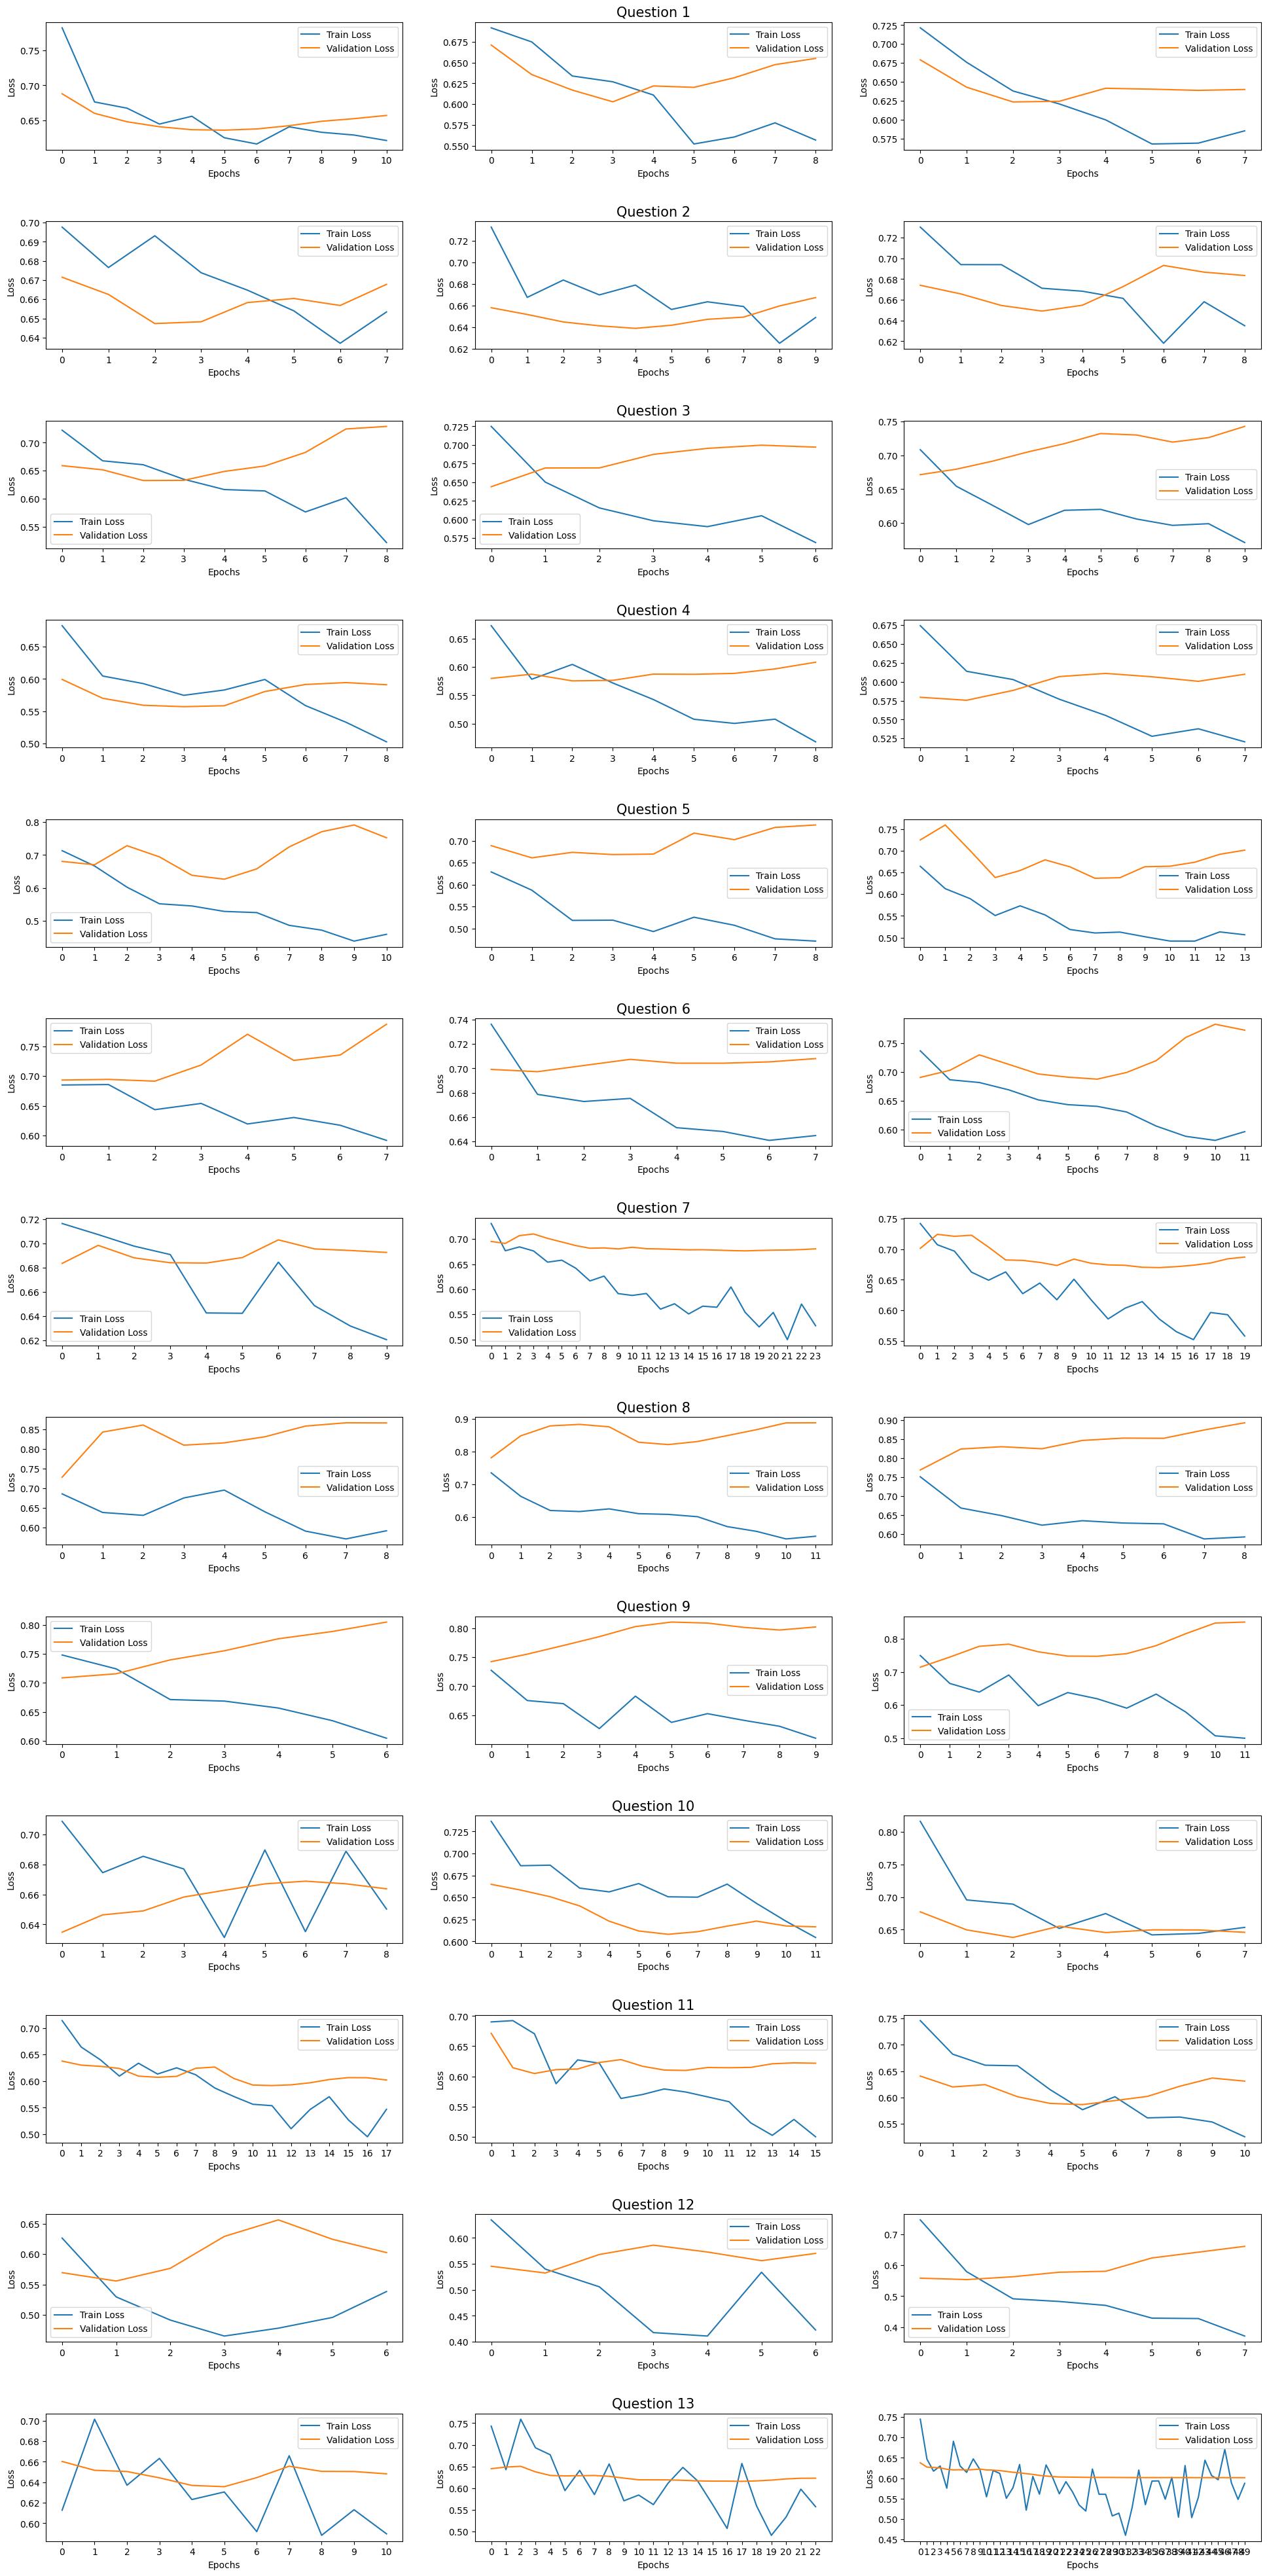

In [ ]:
import matplotlib.pyplot as plt

def plot_tuple_grid(data):
    # Create the figure and axes
    fig, axes = plt.subplots(nrows=len(data), ncols=3, figsize=(20, 40))

    # Iterate over the data and plot each tuple in the corresponding axes
    for i, tuple_data in enumerate(data):
        j = 0
        axes[i][1].set_title(f"Question {i+1}", fontsize=15)
        for tensor_list in tuple_data:
            ax = axes[i][j]

            # Plot the tensors using your desired plot function
            # For example, assuming each tensor list contains x and y coordinates:
            train = [tensor.cpu() for tensor in tensor_list[0]]
            val = [tensor.cpu() for tensor in tensor_list[1]]

            ax.plot(train, label="Train Loss")
            ax.plot(val, label="Validation Loss")

            # Set labels and legend
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()

            num_epochs = len(train)
            x_ticks = range(num_epochs)
            ax.set_xticks(x_ticks)

            j += 1

    # Adjust spacing and layout
    fig.tight_layout(pad=3)

    # Show the plot
    plt.show()


plot_tuple_grid(loss_history)

In [ ]:
a = data[["question","question_text"]].drop_duplicates().merge(results,on="question").sort_values("question").reset_index(drop=True)
a

,question,question_text,V. F1,V. F1 std,V. auc,V. auc std,V. recall,V. recall std,T. F1,T. F1 std,T. auc,T. auc std,T. recall,T. recall std
0,0,how are you doing today,0.757,0.029,0.675,0.074,0.822,0.102,0.740,0.071,0.781,0.074,0.731,0.077
1,1,when was the last time you argued with someone...,0.764,0.015,0.566,0.033,0.979,0.036,0.567,0.026,0.432,0.033,0.707,0.023
2,2,how are you at controlling your temper,0.727,0.069,0.718,0.075,0.810,0.041,0.611,0.078,0.603,0.075,0.613,0.167
3,3,what are you most proud of in your life,0.802,0.025,0.760,0.049,0.889,0.077,0.671,0.014,0.634,0.049,0.750,0.000
4,4,how easy is it for you to get a good night's s...,0.750,0.016,0.748,0.027,0.714,0.000,0.710,0.027,0.769,0.027,0.708,0.042
5,5,have you been diagnosed with depression,0.727,0.012,0.700,0.044,0.718,0.044,0.646,0.007,0.617,0.044,0.621,0.052
6,6,have you ever been diagnosed with p_t_s_d,0.690,0.011,0.498,0.013,1.000,0.000,0.678,0.024,0.523,0.013,0.783,0.087
7,7,what did you study at school,0.713,0.013,0.590,0.018,0.923,0.077,0.521,0.125,0.491,0.018,0.500,0.182
8,8,how would your best friend describe you,0.486,0.118,0.338,0.020,0.564,0.194,0.534,0.010,0.555,0.020,0.470,0.069
9,9,how have you been feeling lately,0.821,0.031,0.788,0.033,0.881,0.082,0.742,0.024,0.764,0.033,0.710,0.050


In [ ]:
results.to_csv("/content/gdrive/MyDrive/daiwoz/Qresults/multimodal_attention.csv")